In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.tabular import *

In [3]:
# from image_tabular.core import *
# from image_tabular.dataset import *
# from image_tabular.model import *
# from image_tabular.metric import *
from importlib import reload

import image_tabular.core;reload(image_tabular.core)
from image_tabular.core import *

import image_tabular.dataset;reload(image_tabular.dataset)
from image_tabular.dataset import *


import image_tabular.model;reload(image_tabular.model)
from image_tabular.model import *


import image_tabular.metric;reload(image_tabular.metric)
from image_tabular.metric import *

In [5]:
# use gpu by default if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [7]:
data_path = Path("./data/artifact-technology-classification/")

In [8]:
train_df = pd.read_csv(data_path/"train_df.csv",index_col=0)
test_df = pd.read_csv(data_path/"test_df.csv",index_col=0)

print(len(train_df), len(test_df))

100 24


In [10]:
train_df['target'] = train_df['cat'].map({'self_created':1,'other':0})

In [11]:
# extremely unbalanced dataset, most of the images are benign
train_df["target"].value_counts(normalize=True)

0    0.52
1    0.48
Name: target, dtype: float64

In [35]:
train_df.head()

,artifact_id,in-class_submissions,after-class_submisson,sharing_outcomes,student_discussions,learning_groups,cat,wv_0,wv_1,wv_2,...,wv_291,wv_292,wv_293,wv_294,wv_295,wv_296,wv_297,wv_298,wv_299,target
57,5cd9c17c-58d3-489d-9792-5508f81bb787,0.0,0.0,24.0,8.0,2.0,self_created,0.070218,-0.102515,-0.016235,...,0.024171,0.040959,0.081752,0.072646,0.027733,0.045051,-0.081938,0.047864,-0.038240,1
38,0e66cb40-5c24-4fab-9c61-3d7ae68912ef,57.0,0.0,0.0,0.0,0.0,self_created,0.187361,-0.290223,-0.006974,...,-0.076416,0.056014,0.028710,0.266044,0.059166,0.126273,0.067106,-0.002292,-0.264407,1
95,bad61580-cf32-46f4-9b1e-8cefbd7d18a3,0.0,18.0,0.0,0.0,0.0,other,0.133336,-0.287600,-0.057537,...,0.006637,-0.008706,0.118841,0.116768,-0.185281,0.009150,0.158298,-0.356028,0.069724,0
76,fff3970c-abd2-4f39-85f6-739e0d50a090,0.0,30.0,0.0,0.0,0.0,other,0.206696,-0.353678,0.042312,...,-0.063292,0.066468,-0.026278,0.028213,0.053822,-0.092839,0.085687,-0.094358,-0.018746,0
89,e7753e34-c9db-4d10-88ba-895ae77971ef,0.0,0.0,0.0,0.0,0.0,other,0.286179,0.026915,0.072522,...,0.007721,-0.194561,0.009524,0.030890,0.110367,0.106582,0.063954,-0.056724,0.090624,0


## Image data

In [12]:
tfms = get_transforms(do_flip=False, max_rotate=1.)
size = 128

In [13]:
# idx for validation, shared by image and tabular data
val_idx = get_valid_index(train_df)
len(val_idx)

20

In [14]:
# load image data using train_df and prepare fastai LabelLists
image_data = (ImageList.from_df(train_df, path=data_path, cols="artifact_id",
                               folder="train", suffix=".jpg")
              .split_by_idx(val_idx)
              .label_from_df(cols="target")
              .transform(tfms, size=size))

# add test data so that we can make predictions
test_image_data = ImageList.from_df(test_df, path=data_path, cols="artifact_id",
                                    folder="test", suffix=".jpg")
image_data.add_test(test_image_data)

LabelLists;

Train: LabelList (80 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
1,1,0,0,1
Path: data/artifact-technology-classification;

Valid: LabelList (20 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,1,0,1,0
Path: data/artifact-technology-classification;

Test: LabelList (24 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: data/artifact-technology-classification

1


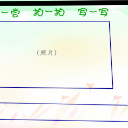

In [15]:
# show one example image
print(image_data.train[0][1])
image_data.train[0][0]

## Tabular data

In [16]:
dep_var = 'target'
# cat_names = []
cont_names = ['in-class_submissions', 'after-class_submisson', 'sharing_outcomes', 'student_discussions', 'learning_groups']+['wv_{}'.format(i) for i in np.arange(300)]
procs = [FillMissing, Categorify, Normalize]

In [17]:
tab_data = (TabularList.from_df(train_df, path=data_path, 
#                                 cat_names=cat_names, 
                                cont_names=cont_names, procs=procs)
                           .split_by_idx(val_idx)
                           .label_from_df(cols=dep_var))

In [18]:
# add test
tab_data.add_test(TabularList.from_df(test_df, 
#                                       cat_names=cat_names,
                                      cont_names=cont_names,
                                      processor = tab_data.train.x.processor))

LabelLists;

Train: LabelList (80 items)
x: TabularList
in-class_submissions -0.5836; after-class_submisson -0.4067; sharing_outcomes 0.9726; student_discussions 1.3144; learning_groups 1.6325; wv_0 -0.7263; wv_1 0.7159; wv_2 -0.3787; wv_3 2.0108; wv_4 -0.6269; wv_5 0.2786; wv_6 -0.7447; wv_7 -0.7031; wv_8 -0.5473; wv_9 -0.0342; wv_10 1.1735; wv_11 -1.0205; wv_12 -0.0840; wv_13 -0.6097; wv_14 -0.2191; wv_15 -0.5560; wv_16 0.1862; wv_17 -0.2720; wv_18 0.1522; wv_19 -0.2519; wv_20 -0.4962; wv_21 -0.1917; wv_22 -1.0496; wv_23 -1.0261; wv_24 0.7936; wv_25 0.5795; wv_26 1.3470; wv_27 1.3797; wv_28 0.5696; wv_29 -0.4382; wv_30 -0.3392; wv_31 0.2124; wv_32 -0.1380; wv_33 0.2654; wv_34 0.1112; wv_35 -0.7252; wv_36 -1.2559; wv_37 -0.7986; wv_38 0.4583; wv_39 -0.6996; wv_40 -0.7374; wv_41 -1.2644; wv_42 -1.9532; wv_43 0.7670; wv_44 0.2775; wv_45 0.1254; wv_46 0.4275; wv_47 0.6720; wv_48 -1.3113; wv_49 -1.4316; wv_50 1.1535; wv_51 -0.8044; wv_52 0.0902; wv_53 -0.6439; wv_54 -0.5621; wv_55 -0.5866

## Integrate image and tabular data

In [19]:
integrate_train, integrate_valid, integrate_test = get_imagetabdatasets(image_data, tab_data)

In [20]:
# package train, valid, and test datasets into a fastai databunch
bs = 32

db = DataBunch.create(integrate_train, integrate_valid, integrate_test,
                      path=data_path, bs=bs)
db

DataBunch;

Train: <image_tabular.dataset.ImageTabDataset object at 0x7fb95c0c79d0>;

Valid: <image_tabular.dataset.ImageTabDataset object at 0x7fb95c0c7ad0>;

Test: <image_tabular.dataset.ImageTabDataset object at 0x7fb95c0c7b50>

In [21]:
# image normalization with imagenet_stats
db.norm, db.denorm = normalize_funcs_image_tab(*imagenet_stats)
db.add_tfm(db.norm)

In [22]:
# check the shape of one batch
x, y = next(iter(db.train_dl))
len(x)

2

In [23]:
# images
x[0].shape

torch.Size([32, 3, 128, 128])

In [24]:
# categorical and continuous tabular data 
x[1][0].shape, x[1][1].shape

(torch.Size([32]), torch.Size([32, 305]))

In [25]:
# targets
y.shape

torch.Size([32])

## Model that trains on image and tabular data simultaneously

In [26]:
# cnn model for images, use Resnet50 as an example
cnn_arch = models.resnet50

# cnn_out_sz is the output size of the cnn model that will be concatenated with tabular model output
cnn_out_sz = 256

# use fastai functions to get a cnn model
image_data_db = image_data.databunch()
image_data_db.c = cnn_out_sz
cnn_learn = cnn_learner(image_data_db, cnn_arch, ps=0.2)
cnn_model = cnn_learn.model

In [27]:
# get embedding sizes of categorical data
emb_szs = tab_data.train.get_emb_szs()

# output size of the tabular model that will be concatenated with cnn model output
tab_out_sz = 8

# use fastai functions to get a tabular model
tabular_model = TabularModel(emb_szs, len(cont_names), out_sz=tab_out_sz, layers=[8], ps=0.2)
tabular_model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(305, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=305, out_features=8, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=8, out_features=8, bias=True)
  )
)

In [28]:
# get an integrated model that combines the two components and concatenate their outputs
# which will pass through additional fully connected layers
integrate_model = CNNTabularModel(cnn_model,
                                  tabular_model,
                                  layers = [cnn_out_sz + tab_out_sz, 32],
                                  ps=0.2,
                                  out_sz=2).to(device)

In [29]:
# check model output dimension, should be (bs, 2)
integrate_model(*x).shape

torch.Size([32, 2])

In [30]:
# adjust loss function weight because the dataset is extremely unbalanced
weights = [1/(1-train_df["target"].mean()), 1/train_df["target"].mean()]
loss_func = CrossEntropyFlat(weight=torch.FloatTensor(weights).to(device))

In [31]:
# package everything in a fastai learner, add auc roc score as a metric
learn = Learner(db, integrate_model, metrics=[accuracy, ROCAUC()], loss_func=loss_func)

In [32]:
# organize layer groups in order to use differential learning rates provided by fastai
# the first two layer groups are earlier layers of resnet
# the last layer group consists of the fully connected layers of cnn model, tabular model,
# and final fully connected layers for the concatenated data
learn.layer_groups = [nn.Sequential(*flatten_model(cnn_learn.layer_groups[0])),
                      nn.Sequential(*flatten_model(cnn_learn.layer_groups[1])),
                      nn.Sequential(*(flatten_model(cnn_learn.layer_groups[2]) +
                                      flatten_model(integrate_model.tabular_model) +
                                      flatten_model(integrate_model.layers)))]

## Training

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


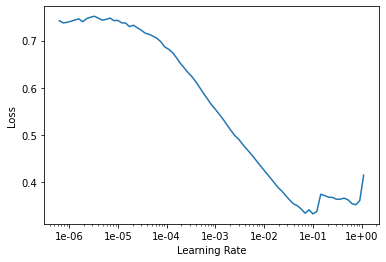

In [34]:
# find learning rate to train the last layer group first 
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [33]:
# train
learn.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,accuracy,rocauc,time
0,0.781026,0.718998,0.400000,0.373737,00:09
1,0.785482,0.687236,0.450000,0.565657,00:08
2,0.757815,0.664192,0.550000,0.707071,00:09
3,0.707414,0.642579,0.600000,0.737374,00:08
4,0.657403,0.601325,0.700000,0.848485,00:08
5,0.614847,0.554022,0.700000,0.878788,00:08
6,0.578914,0.509489,0.750000,0.919192,00:07
7,0.546134,0.470240,0.800000,0.959596,00:08
8,0.518247,0.437759,0.800000,0.969697,00:08
9,0.496576,0.423093,0.850000,0.979798,00:08


In [34]:
# unfreeze all layer groups to train the entire model using differential learning rates
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,rocauc,time
0,0.372290,0.409358,0.850000,0.989899,00:08
1,0.342217,0.386340,0.900000,0.989899,00:09
2,0.328985,0.367895,0.900000,1.000000,00:09
3,0.315038,0.347436,0.900000,1.000000,00:08
4,0.311147,0.346869,0.900000,1.000000,00:09


The model achieved an ROC AUC score of about 0.87 on the validation set.

## Prediction

In [36]:
# make predictions for the test set
preds, y = learn.get_preds(DatasetType.Test)

In [37]:
preds

tensor([[0.9787, 0.0213],
        [0.0717, 0.9283],
        [0.9241, 0.0759],
        [0.9301, 0.0699],
        [0.1979, 0.8021],
        [0.6002, 0.3998],
        [0.5785, 0.4215],
        [0.9056, 0.0944],
        [0.1367, 0.8633],
        [0.6567, 0.3433],
        [0.0766, 0.9234],
        [0.8733, 0.1267],
        [0.8656, 0.1344],
        [0.8026, 0.1974],
        [0.9158, 0.0842],
        [0.7097, 0.2903],
        [0.9318, 0.0682],
        [0.2460, 0.7540],
        [0.5899, 0.4101],
        [0.0373, 0.9627],
        [0.9816, 0.0184],
        [0.0801, 0.9199],
        [0.1329, 0.8671],
        [0.8837, 0.1163],
        [0.1553, 0.8447],
        [0.3889, 0.6111]])